In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("dataset.csv", delimiter=";")

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   business_code           50000 non-null  object 
 1   cust_number             50000 non-null  object 
 2   name_customer           50000 non-null  object 
 3   clear_date              40000 non-null  object 
 4   buisness_year           50000 non-null  float64
 5   doc_id                  50000 non-null  float64
 6   posting_date            50000 non-null  object 
 7   document_create_date    50000 non-null  int64  
 8   document_create_date.1  50000 non-null  int64  
 9   due_in_date             50000 non-null  float64
 10  invoice_currency        50000 non-null  object 
 11  document type           50000 non-null  object 
 12  posting_id              50000 non-null  float64
 13  area_business           0 non-null      float64
 14  total_open_amount       50000 non-null

,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,invoice_currency,document type,posting_id,area_business,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen
0,U001,200769623,WAL-MAR corp,2020-02-11 00:00,2020.0,1.930438e+09,2020-01-26,20200125,20200126,20200210.0,USD,RV,1.0,NaN,54273.28,20200126.0,NAH4,1.930438e+09,0
1,U001,200980828,BEN E,2019-08-08 00:00,2019.0,1.929646e+09,2019-07-22,20190722,20190722,20190811.0,USD,RV,1.0,NaN,79656.60,20190722.0,NAD1,1.929646e+09,0
2,U001,200792734,MDV/ trust,2019-12-30 00:00,2019.0,1.929874e+09,2019-09-14,20190914,20190914,20190929.0,USD,RV,1.0,NaN,2253.86,20190914.0,NAA8,1.929874e+09,0
3,CA02,140105686,SYSC llc,NaN,2020.0,2.960623e+09,2020-03-30,20200330,20200330,20200410.0,CAD,RV,1.0,NaN,3299.70,20200331.0,CA10,2.960623e+09,1
4,U001,200769623,WAL-MAR foundation,2019-11-25 00:00,2019.0,1.930148e+09,2019-11-13,20191113,20191113,20191128.0,USD,RV,1.0,NaN,33133.29,20191113.0,NAH4,1.930148e+09,0


# Rensing

In [2]:
# Funktion för att fixa YYYYMMDD(.0)-datum
def fix_date(col):
    return (
        col.astype(str)
        .str.replace(".0", "", regex=False)  # ta bort .0
        .str.replace(".0", "", regex=False)  # ibland finns dubbelt, säkerhet
        .str.zfill(8)                        # se till att det blir 8 tecken
        .pipe(pd.to_datetime, format="%Y%m%d", errors="coerce")
    )

# Kolumner som måste fixas från YYYYMMDD(.0)
raw_yyyymmdd_cols = [
    "document_create_date",
    "document_create_date.1",
    "due_in_date",
    "baseline_create_date"
]

# Kör fix_date på dessa
for col in raw_yyyymmdd_cols:
    df[col] = fix_date(df[col])

# Kolumner som redan är datumsträngar och bara behöver pd.to_datetime
proper_date_cols = [
    "posting_date",
    "clear_date"
]

for col in proper_date_cols:
    df[col] = pd.to_datetime(df[col], errors="coerce")


In [3]:
print(df["invoice_currency"].value_counts())
print("\n------------")
print(df["cust_payment_terms"].value_counts())
print("\n------------")
print(df.isna().mean().sort_values(ascending=False))


invoice_currency
USD    46081
CAD     3919
Name: count, dtype: int64

------------
cust_payment_terms
NAA8    20118
NAH4    13585
CA10     3800
NAC6     1743
NAM4     1385
        ...  
NATU        1
NAUY        1
C129        1
NATV        1
MC15        1
Name: count, Length: 74, dtype: int64

------------
area_business             1.00000
clear_date                0.20000
invoice_id                0.00012
business_code             0.00000
invoice_currency          0.00000
cust_payment_terms        0.00000
baseline_create_date      0.00000
total_open_amount         0.00000
posting_id                0.00000
document type             0.00000
due_in_date               0.00000
cust_number               0.00000
document_create_date.1    0.00000
document_create_date      0.00000
posting_date              0.00000
doc_id                    0.00000
buisness_year             0.00000
name_customer             0.00000
isOpen                    0.00000
dtype: float64


In [4]:
# Hämta alla unika kundnummer
unique_customers_number = df["cust_number"].unique()

# Sortera för stabil ordning (valfritt, men bra för reproducerbarhet)
unique_customers = sorted(unique_customers_number)

# Skapa mapping: riktig kund → artificiellt ID
mapping = {
    cust: 100000 + i
    for i, cust in enumerate(unique_customers)
}

# Lägg till kolumnen
df["customer_alt_id"] = df["cust_number"].map(mapping)

# Lika många kundnamnnamn som kundnummer?
print(f"Unika nummer: {df["customer_alt_id"].nunique()}")
print(f"Unika namn: {df["name_customer"].nunique()}")

Unika nummer: 1099
Unika namn: 4197


In [5]:
# 1. Normalisera namn
df["name_normalized"] = (
    df["name_customer"]
    .astype(str)
    .str.lower()
    .str.replace(r"[^a-z0-9 ]", "", regex=True)   # ta bort specialtecken
    .str.replace(r"\s+", " ", regex=True)         # collapsa multipla mellanslag
    .str.strip()
)

# 2. Räkna hur ofta varje normaliserat namn förekommer per alt_id
name_counts = (
    df.groupby(["customer_alt_id", "name_normalized"])
    .size()
    .reset_index(name="count")
)

# 3. Plocka det vanligaste namnet per kund_alt_id
most_frequent_names = (
    name_counts
    .sort_values(["customer_alt_id", "count"], ascending=[True, False])
    .drop_duplicates(subset=["customer_alt_id"])
    .rename(columns={"name_normalized": "customer_clean_name"})
    .loc[:, ["customer_alt_id", "customer_clean_name"]]
)

# 4. Lägg till 'customer_clean_name' i df
df = df.merge(most_frequent_names, on="customer_alt_id", how="left")

# Lika många kundnamn som kundnummer nu?
print(f"Unika nummer: {df['customer_alt_id'].nunique()}")
print(f"Unika namn:   {df['customer_clean_name'].nunique()}")

df.head(15)

Unika nummer: 1099
Unika namn:   1056


,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,...,posting_id,area_business,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen,customer_alt_id,name_normalized,customer_clean_name
0,U001,200769623,WAL-MAR corp,2020-02-11,2020.0,1.930438e+09,2020-01-26,2020-01-25,2020-01-26,2020-02-10,...,1.0,NaN,54273.28,2020-01-26,NAH4,1.930438e+09,0,100908,walmar corp,walmar trust
1,U001,200980828,BEN E,2019-08-08,2019.0,1.929646e+09,2019-07-22,2019-07-22,2019-07-22,2019-08-11,...,1.0,NaN,79656.60,2019-07-22,NAD1,1.929646e+09,0,101072,ben e,ben e associates
2,U001,200792734,MDV/ trust,2019-12-30,2019.0,1.929874e+09,2019-09-14,2019-09-14,2019-09-14,2019-09-29,...,1.0,NaN,2253.86,2019-09-14,NAA8,1.929874e+09,0,100977,mdv trust,mdv corporation
3,CA02,140105686,SYSC llc,NaT,2020.0,2.960623e+09,2020-03-30,2020-03-30,2020-03-30,2020-04-10,...,1.0,NaN,3299.70,2020-03-31,CA10,2.960623e+09,1,100435,sysc llc,sysc systems
4,U001,200769623,WAL-MAR foundation,2019-11-25,2019.0,1.930148e+09,2019-11-13,2019-11-13,2019-11-13,2019-11-28,...,1.0,NaN,33133.29,2019-11-13,NAH4,1.930148e+09,0,100908,walmar foundation,walmar trust
5,CA02,140106181,THE corporation,2019-12-04,2019.0,2.960581e+09,2019-09-20,2019-09-20,2019-09-20,2019-10-04,...,1.0,NaN,22225.84,2019-09-24,CA10,2.960581e+09,0,100447,the corporation,the corp
6,U001,200769623,WAL-MAR in,2019-11-12,2019.0,1.930083e+09,2019-11-01,2019-10-31,2019-11-01,2019-11-16,...,1.0,NaN,7358.49,2019-11-01,NAH4,1.930083e+09,0,100908,walmar in,walmar trust
7,U001,200744019,TARG us,NaT,2020.0,1.930659e+09,2020-03-19,2020-03-18,2020-03-19,2020-04-03,...,1.0,NaN,11173.02,2020-03-19,NAA8,1.930659e+09,1,100852,targ us,targ systems
8,U001,200769623,WAL-MAR corp,2019-06-18,2019.0,1.929440e+09,2019-06-07,2019-06-05,2019-06-07,2019-06-22,...,1.0,NaN,15995.04,2019-06-07,NAH4,1.929440e+09,0,100908,walmar corp,walmar trust
9,U001,200762301,C&S WH systems,2019-03-06,2019.0,1.928819e+09,2019-02-20,2019-02-19,2019-02-20,2019-03-07,...,1.0,NaN,28.63,2019-02-20,NAC6,1.928819e+09,0,100891,cs wh systems,cs wh systems


In [6]:
# 5. Ta reda på vilka clean-namn som delas av flera kund_alt_id
name_counts_per_clean = most_frequent_names["customer_clean_name"].value_counts()
shared_names = name_counts_per_clean[name_counts_per_clean > 1].index  # namn med >1 alt-id

# 6. Skapa ett display-namn som är unikt per kund_alt_id
def make_display_name(row):
    base = row["customer_clean_name"]
    # Om basnamnet delas av flera IDs → lägg till alt-id
    if base in shared_names:
        return f"{base} {row['customer_alt_id']}"
    else:
        return base

most_frequent_names["customer_display_name"] = most_frequent_names.apply(
    make_display_name, axis=1
)

# 7. Mappa in display-namnet i huvud-df
df = df.merge(
    most_frequent_names[["customer_alt_id", "customer_display_name"]],
    on="customer_alt_id",
    how="left"
)

# Snabb koll
print("Exempel på namn med flera ID:")
ex = most_frequent_names[
    most_frequent_names["customer_clean_name"].isin(shared_names)
].head(10)
print(ex)

# Lika många kundnamn som kundnummer nu?
print(f"Unika nummer: {df['customer_alt_id'].nunique()}")
print(f"Unika namn: {df['customer_display_name'].nunique()}")

df.head(10)


Exempel på namn med flera ID:
     customer_alt_id  customer_clean_name       customer_display_name
2             100001     gree corporation     gree corporation 100001
86            100028                unite                unite 100028
107           100033  sysco in foundation  sysco in foundation 100033
112           100034        so associates        so associates 100034
151           100048                us us                us us 100048
182           100059               dec co               dec co 100059
192           100062    perfor foundation    perfor foundation 100062
218           100068               perfor               perfor 100068
230           100073            perfor co            perfor co 100073
308           100095     sysc corporation     sysc corporation 100095
Unika nummer: 1099
Unika namn: 1099


,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,...,area_business,total_open_amount,baseline_create_date,cust_payment_terms,invoice_id,isOpen,customer_alt_id,name_normalized,customer_clean_name,customer_display_name
0,U001,200769623,WAL-MAR corp,2020-02-11,2020.0,1.930438e+09,2020-01-26,2020-01-25,2020-01-26,2020-02-10,...,NaN,54273.28,2020-01-26,NAH4,1.930438e+09,0,100908,walmar corp,walmar trust,walmar trust
1,U001,200980828,BEN E,2019-08-08,2019.0,1.929646e+09,2019-07-22,2019-07-22,2019-07-22,2019-08-11,...,NaN,79656.60,2019-07-22,NAD1,1.929646e+09,0,101072,ben e,ben e associates,ben e associates
2,U001,200792734,MDV/ trust,2019-12-30,2019.0,1.929874e+09,2019-09-14,2019-09-14,2019-09-14,2019-09-29,...,NaN,2253.86,2019-09-14,NAA8,1.929874e+09,0,100977,mdv trust,mdv corporation,mdv corporation
3,CA02,140105686,SYSC llc,NaT,2020.0,2.960623e+09,2020-03-30,2020-03-30,2020-03-30,2020-04-10,...,NaN,3299.70,2020-03-31,CA10,2.960623e+09,1,100435,sysc llc,sysc systems,sysc systems
4,U001,200769623,WAL-MAR foundation,2019-11-25,2019.0,1.930148e+09,2019-11-13,2019-11-13,2019-11-13,2019-11-28,...,NaN,33133.29,2019-11-13,NAH4,1.930148e+09,0,100908,walmar foundation,walmar trust,walmar trust
5,CA02,140106181,THE corporation,2019-12-04,2019.0,2.960581e+09,2019-09-20,2019-09-20,2019-09-20,2019-10-04,...,NaN,22225.84,2019-09-24,CA10,2.960581e+09,0,100447,the corporation,the corp,the corp 100447
6,U001,200769623,WAL-MAR in,2019-11-12,2019.0,1.930083e+09,2019-11-01,2019-10-31,2019-11-01,2019-11-16,...,NaN,7358.49,2019-11-01,NAH4,1.930083e+09,0,100908,walmar in,walmar trust,walmar trust
7,U001,200744019,TARG us,NaT,2020.0,1.930659e+09,2020-03-19,2020-03-18,2020-03-19,2020-04-03,...,NaN,11173.02,2020-03-19,NAA8,1.930659e+09,1,100852,targ us,targ systems,targ systems
8,U001,200769623,WAL-MAR corp,2019-06-18,2019.0,1.929440e+09,2019-06-07,2019-06-05,2019-06-07,2019-06-22,...,NaN,15995.04,2019-06-07,NAH4,1.929440e+09,0,100908,walmar corp,walmar trust,walmar trust
9,U001,200762301,C&S WH systems,2019-03-06,2019.0,1.928819e+09,2019-02-20,2019-02-19,2019-02-20,2019-03-07,...,NaN,28.63,2019-02-20,NAC6,1.928819e+09,0,100891,cs wh systems,cs wh systems,cs wh systems


In [7]:
closed_invoices = df[df["isOpen"] == 0].copy()
open_invoices = df[df["isOpen"] == 1].copy()

print(closed_invoices["clear_date"].isna().mean())

closed_invoices["days_to_due"] = (closed_invoices["due_in_date"] - closed_invoices["posting_date"]).dt.days
closed_invoices["days_to_clear"] = (closed_invoices["clear_date"] - closed_invoices["posting_date"]).dt.days
closed_invoices["delay_days"] = (closed_invoices["clear_date"] - closed_invoices["due_in_date"]).dt.days

closed_invoices.head(15)

0.0


,business_code,cust_number,name_customer,clear_date,buisness_year,doc_id,posting_date,document_create_date,document_create_date.1,due_in_date,...,cust_payment_terms,invoice_id,isOpen,customer_alt_id,name_normalized,customer_clean_name,customer_display_name,days_to_due,days_to_clear,delay_days
0,U001,200769623,WAL-MAR corp,2020-02-11,2020.0,1.930438e+09,2020-01-26,2020-01-25,2020-01-26,2020-02-10,...,NAH4,1.930438e+09,0,100908,walmar corp,walmar trust,walmar trust,15,16,1
1,U001,200980828,BEN E,2019-08-08,2019.0,1.929646e+09,2019-07-22,2019-07-22,2019-07-22,2019-08-11,...,NAD1,1.929646e+09,0,101072,ben e,ben e associates,ben e associates,20,17,-3
2,U001,200792734,MDV/ trust,2019-12-30,2019.0,1.929874e+09,2019-09-14,2019-09-14,2019-09-14,2019-09-29,...,NAA8,1.929874e+09,0,100977,mdv trust,mdv corporation,mdv corporation,15,107,92
4,U001,200769623,WAL-MAR foundation,2019-11-25,2019.0,1.930148e+09,2019-11-13,2019-11-13,2019-11-13,2019-11-28,...,NAH4,1.930148e+09,0,100908,walmar foundation,walmar trust,walmar trust,15,12,-3
5,CA02,140106181,THE corporation,2019-12-04,2019.0,2.960581e+09,2019-09-20,2019-09-20,2019-09-20,2019-10-04,...,CA10,2.960581e+09,0,100447,the corporation,the corp,the corp 100447,14,75,61
6,U001,200769623,WAL-MAR in,2019-11-12,2019.0,1.930083e+09,2019-11-01,2019-10-31,2019-11-01,2019-11-16,...,NAH4,1.930083e+09,0,100908,walmar in,walmar trust,walmar trust,15,11,-4
8,U001,200769623,WAL-MAR corp,2019-06-18,2019.0,1.929440e+09,2019-06-07,2019-06-05,2019-06-07,2019-06-22,...,NAH4,1.929440e+09,0,100908,walmar corp,walmar trust,walmar trust,15,11,-4
9,U001,200762301,C&S WH systems,2019-03-06,2019.0,1.928819e+09,2019-02-20,2019-02-19,2019-02-20,2019-03-07,...,NAC6,1.928819e+09,0,100891,cs wh systems,cs wh systems,cs wh systems,15,14,-1
11,U001,200743129,BROOKS co,2019-01-22,2019.0,1.928551e+09,2019-01-02,2019-01-02,2019-01-02,2019-01-17,...,NAA8,1.928551e+09,0,100848,brooks co,brooks foundation,brooks foundation,15,20,5
12,U001,200186937,SYSC corporation,2019-05-06,2019.0,1.929152e+09,2019-04-15,2019-04-15,2019-04-15,2019-04-30,...,NAA8,1.929152e+09,0,100549,sysc corporation,sysc,sysc,15,21,6


In [8]:
def payment_status(delay):
    if pd.isna(delay):
        return "unknown"
    if delay < -1:
        return "early"
    elif -1 <= delay <= 1:
        return "on_time"
    else:
        return "late"

closed_invoices["payment_status"] = closed_invoices["delay_days"].apply(payment_status)

closed_invoices["payment_status"].value_counts(normalize=True)

print(f"\n--- Describe\n{closed_invoices["delay_days"].describe()}")
print(f"\n--- Quantiles\n{closed_invoices["delay_days"].quantile([0.95, 0.99, 0.999])}")
closed_invoices.groupby("payment_status")["delay_days"].agg(["count", "mean", "median"])


--- Describe
count    40000.000000
mean         0.837700
std         10.831701
min        -89.000000
25%         -3.000000
50%          0.000000
75%          2.000000
max        204.000000
Name: delay_days, dtype: float64

--- Quantiles
0.950    10.000
0.990    50.000
0.999    94.001
Name: delay_days, dtype: float64


,count,mean,median
payment_status,,,
early,12178,-5.930695,-4.0
late,11970,8.650459,3.0
on_time,15852,0.137901,0.0


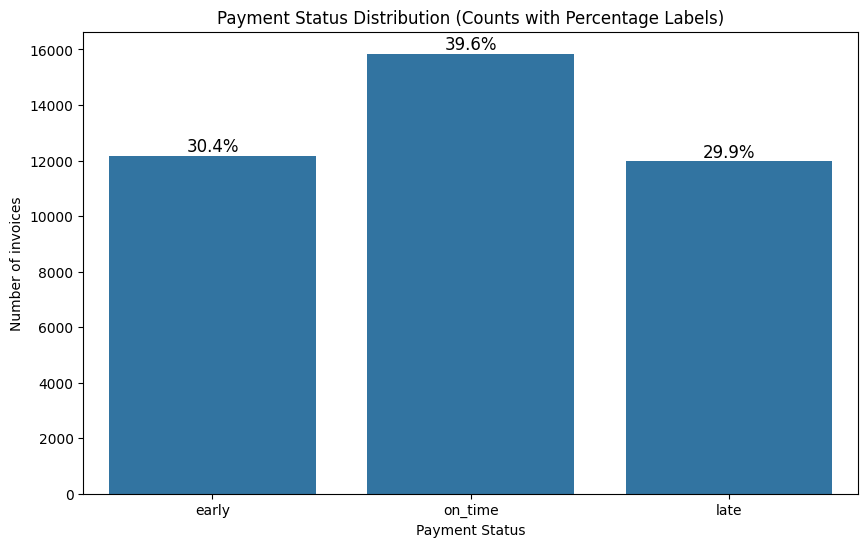

In [9]:
# Bestäm önskad ordning
order = ["early", "on_time", "late"]

# Beräkna antal och procent i rätt ordning
status_counts = closed_invoices["payment_status"].value_counts().reindex(order)
status_pct = (status_counts / status_counts.sum() * 100).reindex(order)

plt.figure(figsize=(10,6))
ax = sns.barplot(x=status_counts.index, 
                 y=status_counts.values,
                 order=order)

plt.title("Payment Status Distribution (Counts with Percentage Labels)")
plt.ylabel("Number of invoices")
plt.xlabel("Payment Status")

# Lägg procent över respektive stapel
for i, (pct, count) in enumerate(zip(status_pct.values, status_counts.values)):
    plt.text(
        i,
        count,
        f"{pct:.1f}%",
        ha='center',
        va='bottom',
        fontsize=12
    )

plt.show()


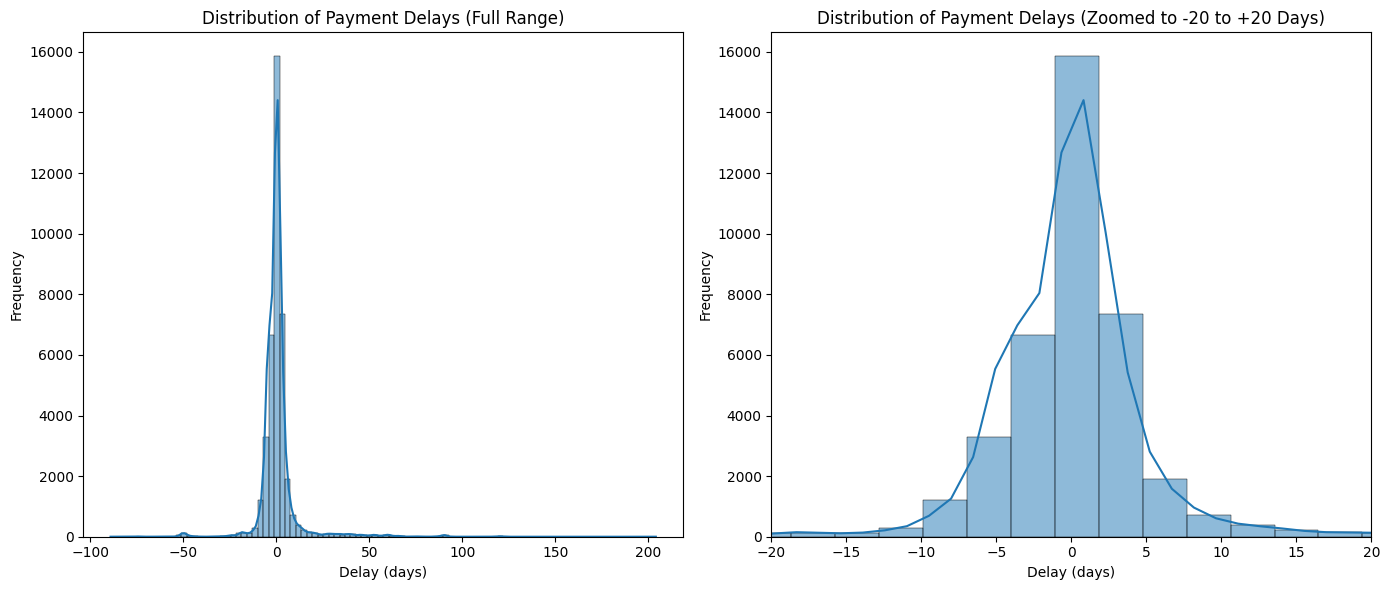

In [10]:
plt.figure(figsize=(14,6))

# --- Plot 1: Full range ---
plt.subplot(1, 2, 1)
sns.histplot(closed_invoices["delay_days"], bins=100, kde=True)
plt.title("Distribution of Payment Delays (Full Range)")
plt.xlabel("Delay (days)")
plt.ylabel("Frequency")

# --- Plot 2: Zoomed range (-20 to +20 days) ---
plt.subplot(1, 2, 2)
sns.histplot(closed_invoices["delay_days"], bins=100, kde=True)
plt.xlim(-20, 20)
plt.title("Distribution of Payment Delays (Zoomed to -20 to +20 Days)")
plt.xlabel("Delay (days)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [11]:
#1. Försenade dagar per kund (endast positiva dagar räknas)

#Först behöver vi en kolumn som bara räknar dagar efter förfallodatum:
closed_invoices["late_days"] = closed_invoices["delay_days"].clip(lower=0)


# Kostnader för sent betalda fakturor

In [17]:
# ======= 1. Totalt försenat belopp (principal) =======
late_mask = closed_invoices["late_days"] > 0

total_late_principal = closed_invoices.loc[
    late_mask, "total_open_amount"
].sum()

print(f"Total invoice amount of late payments: ${total_late_principal:,.2f}")


# ======= 2. Räntekostnad per faktura (late_cost) =======
annual_rate = 0.10   # 10 %
daily_rate = annual_rate / 365

closed_invoices["late_cost"] = (
    closed_invoices["total_open_amount"] *
    daily_rate *
    closed_invoices["late_days"]
)

total_late_cost = closed_invoices.loc[late_mask, "late_cost"].sum()
print(f"Total cost of late payments (interest-based): ${total_late_cost:,.2f}")


# ======= 3. Kostnad per faktura (median, robust mot outliers) =======
median_cost_per_invoice = closed_invoices.loc[
    late_mask, "late_cost"
].median()

print(f"Median cost per late invoice: ${median_cost_per_invoice:,.2f}")


# ======= 4. Percentiler (för djupare förståelse) =======
percentiles = closed_invoices.loc[late_mask, "late_cost"].quantile(
    [0.50, 0.75, 0.90, 0.95]
)

print("\nPercentiles (cost per late invoice):")
for pct, value in percentiles.items():
    print(f"P{int(pct*100):>2}: ${value:,.2f}")


Total invoice amount of late payments: $571,720,594.44
Total cost of late payments (interest-based): $782,159.60
Median cost per late invoice: $13.94

Percentiles (cost per late invoice):
P50: $13.94
P75: $40.44
P90: $106.43
P95: $193.01


# Kostnad per dag / månad

In [23]:
# Kalkylränta / kapitalkostnad
annual_rate = 0.10
daily_rate = annual_rate / 365

# Säkerställ att vi bara jobbar med sena fakturor (late_days > 0)
late_mask = closed_invoices["late_days"] > 0
late_invoices = closed_invoices[late_mask].copy()

# Bygg ett dagligt "schema" där varje rad = en dag då fakturan var sen
daily_rows = []

for idx, row in late_invoices.iterrows():
    # Förseningen börjar dagen efter förfallodatum
    start = row["due_in_date"] + pd.Timedelta(days=1)
    end = row["clear_date"]
    
    if pd.isna(start) or pd.isna(end) or end < start:
        continue  # hoppa över konstiga edge cases
    
    days = pd.date_range(start, end)
    
    daily_rows.append(
        pd.DataFrame({
            "date": days,
            "customer_alt_id": row["customer_alt_id"],
            "customer_display_name": row["customer_display_name"],
            "amount_late": row["total_open_amount"]
        })
    )

# Slå ihop alla dagliga rader
daily_cost_df = pd.concat(daily_rows, ignore_index=True)

# Räkna daglig kostnad per rad
daily_cost_df["daily_cost"] = daily_cost_df["amount_late"] * daily_rate

# Summera kostnad per datum (alla kunder)
daily_total_cost = (
    daily_cost_df
    .groupby("date")["daily_cost"]
    .sum()
    .reset_index()
)

# Lägg till månad på daily_total_cost
daily_total_cost["month"] = daily_total_cost["date"].dt.to_period("M")

# Faktisk kostnad per månad (summa av daily_cost)
monthly_cost = (
    daily_total_cost
    .groupby("month")["daily_cost"]
    .sum()
    .reset_index()
    .rename(columns={"daily_cost": "monthly_cost"})
)

# Antal sena fakturor per månad (baserat på clear_date)
closed_invoices["month"] = closed_invoices["clear_date"].dt.to_period("M")

monthly_invoice_count = (
    closed_invoices[late_mask]
    .groupby("month")["invoice_id"]
    .nunique()
    .reset_index(name="late_invoice_count")
)

# Slå ihop kostnad + antal fakturor
monthly_summary = monthly_cost.merge(
    monthly_invoice_count,
    on="month",
    how="left"
)

# Fyll eventuella NaN i late_invoice_count och gör den numerisk
monthly_summary["late_invoice_count"] = (
    monthly_summary["late_invoice_count"]
    .fillna(0)
    .astype(int)
)

print("Daglig kostnad – exempel:")
display(daily_total_cost.head())

print("Månadssammanfattning – exempel:")
display(monthly_summary.head())


Daglig kostnad – exempel:


,date,daily_cost,month
0,2018-12-25,42.468666,2018-12
1,2018-12-26,42.468666,2018-12
2,2018-12-27,42.468666,2018-12
3,2018-12-28,42.468666,2018-12
4,2018-12-29,42.468666,2018-12


Månadssammanfattning – exempel:


,month,monthly_cost,late_invoice_count
0,2018-12,297.638430,0
1,2019-01,18323.301948,472
2,2019-02,47657.472296,983
3,2019-03,57630.479970,1216
4,2019-04,60322.188337,1266


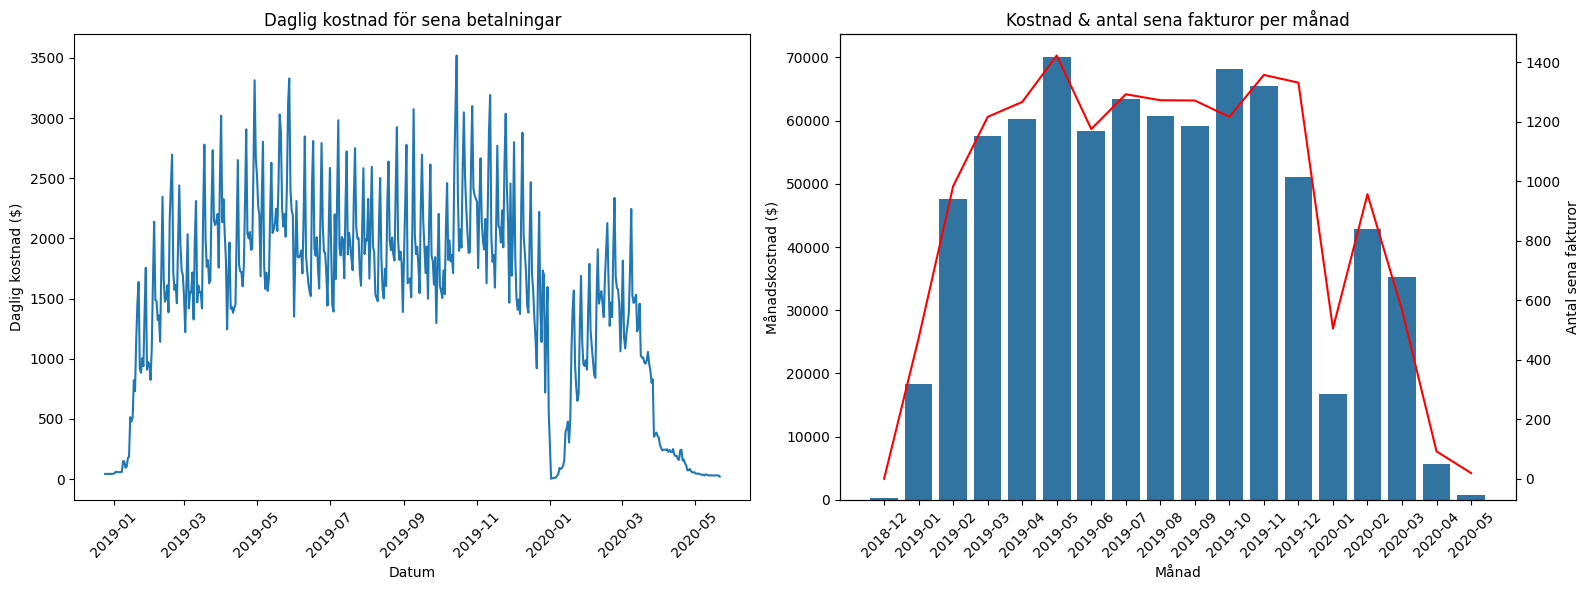

In [25]:
import matplotlib.ticker as mtick

fig, axes = plt.subplots(1, 2, figsize=(16,6))

# --- Vänster: daglig kostnad ---
sns.lineplot(
    data=daily_total_cost,
    x="date",
    y="daily_cost",
    ax=axes[0]
)
axes[0].set_title("Daglig kostnad för sena betalningar")
axes[0].set_xlabel("Datum")
axes[0].set_ylabel("Daglig kostnad ($)")
axes[0].tick_params(axis='x', rotation=45)
axes[0].ticklabel_format(style='plain', axis='y')

# För tydligare labels: gör month till str i plotten
monthly_summary_plot = monthly_summary.copy()
monthly_summary_plot["month_str"] = monthly_summary_plot["month"].astype(str)

# --- Höger: månadskostnad (staplar) + antal sena fakturor (linje) ---
ax1 = axes[1]

# Staplar: månadskostnad
sns.barplot(
    data=monthly_summary_plot,
    x="month_str",
    y="monthly_cost",
    ax=ax1,
)
ax1.set_title("Kostnad & antal sena fakturor per månad")
ax1.set_xlabel("Månad")
ax1.set_ylabel("Månadskostnad ($)")
ax1.tick_params(axis='x', rotation=45)
ax1.ticklabel_format(style='plain', axis='y')

# Linje: antal sena fakturor (sekundäraxeln)
ax2 = ax1.twinx()
sns.lineplot(
    data=monthly_summary_plot,
    x="month_str",
    y="late_invoice_count",
    ax=ax2,
    color="red",
    marker=None
)
ax2.set_ylabel("Antal sena fakturor")
ax2.ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show()


# Kundnivå

In [14]:

# 2. Total försenad tid + antal sena fakturor + genomsnittlig försening

customer_delay_stats = (
    closed_invoices
    .groupby(["customer_alt_id", "customer_display_name"])
    .agg(
        n_invoices=("invoice_id", "count"),
        late_invoices=("late_days", lambda x: (x > 0).sum()),
        total_late_days=("late_days", "sum"),
        avg_late_days=("late_days", "mean"),
        med_late_days=("late_days", "median"),
    )
)

# Gör om till procent och multiplicera med 100
customer_delay_stats["pct_late_invoices"] = (
    customer_delay_stats["late_invoices"] / customer_delay_stats["n_invoices"] * 100
).round(2)  # runda till två decimaler

# Sortera efter de mest problematiska kunderna
customer_delay_stats = customer_delay_stats.sort_values(
    "total_late_days", ascending=False
)

customer_delay_stats.head(10)

closed_invoices["late_cost"] = (
    closed_invoices["total_open_amount"] *
    daily_rate *
    closed_invoices["late_days"]
)

total_cost = closed_invoices["late_cost"].sum()
print(f"Total kostnad för alla sena betalningar: ${total_cost:,.2f}")

median_cost = closed_invoices.loc[closed_invoices["late_days"] > 0, "late_cost"].median()
print(f"Median kostnad per sen faktura: ${median_cost:,.2f}")

late_costs = closed_invoices.loc[closed_invoices["late_days"] > 0, "late_cost"]

percentiles = late_costs.quantile([0.50, 0.75, 0.90, 0.95])
print(percentiles)


# Steg 2 — Beräkna kostnad per faktura
closed_invoices["late_cost"] = (
    closed_invoices["total_open_amount"] * daily_rate * closed_invoices["late_days"]
)

# Lägg till månad (baserat på clear_date – byt till posting_date om du föredrar det)
closed_invoices["month"] = closed_invoices["clear_date"].dt.to_period("M")

# Steg 3 — Summera kostnaden per kund (som tidigare)
customer_cost_stats = (
    closed_invoices
    .groupby(["customer_alt_id", "customer_display_name"])
    .agg(
        n_invoices=("invoice_id", "count"),
        late_invoices=("late_days", lambda x: (x > 0).sum()),
        total_late_days=("late_days", "sum"),
        total_late_cost=("late_cost", "sum"),
        avg_late_cost=("late_cost", "mean"),
        total_invoice_amount=("total_open_amount", "sum"),
    )
    .sort_values("total_late_cost", ascending=False)
    .reset_index()
)

# Steg 4 — Bygg kund × månad-tabell
customer_monthly_cost = (
    closed_invoices
    .groupby(["customer_alt_id", "customer_display_name", "month"])
    .agg(
        monthly_late_cost=("late_cost", "sum")
    )
    .reset_index()
)

# Steg 5 — Räkna snittkostnad per månad per kund
avg_monthly = (
    customer_monthly_cost
    .groupby(["customer_alt_id", "customer_display_name"])
    .agg(
        months_active=("month", "nunique"),
        avg_monthly_late_cost=("monthly_late_cost", "mean"),
    )
    .reset_index()
)

# Steg 6 — Merg:a in månadsdatan i huvudtabellen
customer_cost_stats = customer_cost_stats.merge(
    avg_monthly,
    on=["customer_alt_id", "customer_display_name"],
    how="left"
)

customer_cost_stats.head(10)


Total kostnad för alla sena betalningar: $782,159.60
Median kostnad per sen faktura: $13.94
0.50     13.936395
0.75     40.441630
0.90    106.427620
0.95    193.005699
Name: late_cost, dtype: float64


,customer_alt_id,customer_display_name,n_invoices,late_invoices,total_late_days,total_late_cost,avg_late_cost,total_invoice_amount,months_active,avg_monthly_late_cost
0,101098,kraft f corp,542,542,22857,91424.355271,168.679622,8.100058e+06,9,10158.261697
1,100447,the corp 100447,100,97,6311,53060.379458,530.603795,2.914599e+06,14,3790.027104
2,100469,walm llc,433,433,4156,50868.088896,117.478265,2.185316e+07,15,3391.205926
3,100409,so associates 100409,230,227,1360,44600.031063,193.913179,2.849702e+07,14,3185.716505
4,100405,lob co,415,209,885,26931.178008,64.894405,4.457368e+07,16,1683.198626
5,100908,walmar trust,9581,1684,7148,22203.625825,2.317464,2.163702e+08,15,1480.241722
6,101095,kraft in,444,319,3716,21233.243408,47.822620,9.728802e+06,9,2359.249268
7,100852,targ systems,851,543,2409,15297.852416,17.976325,2.079365e+07,16,956.115776
8,100885,sa associates,1144,885,1819,13399.751619,11.713070,4.000441e+07,17,788.220683
9,100435,sysc systems,284,278,1774,11571.691816,40.745394,8.449148e+06,15,771.446121


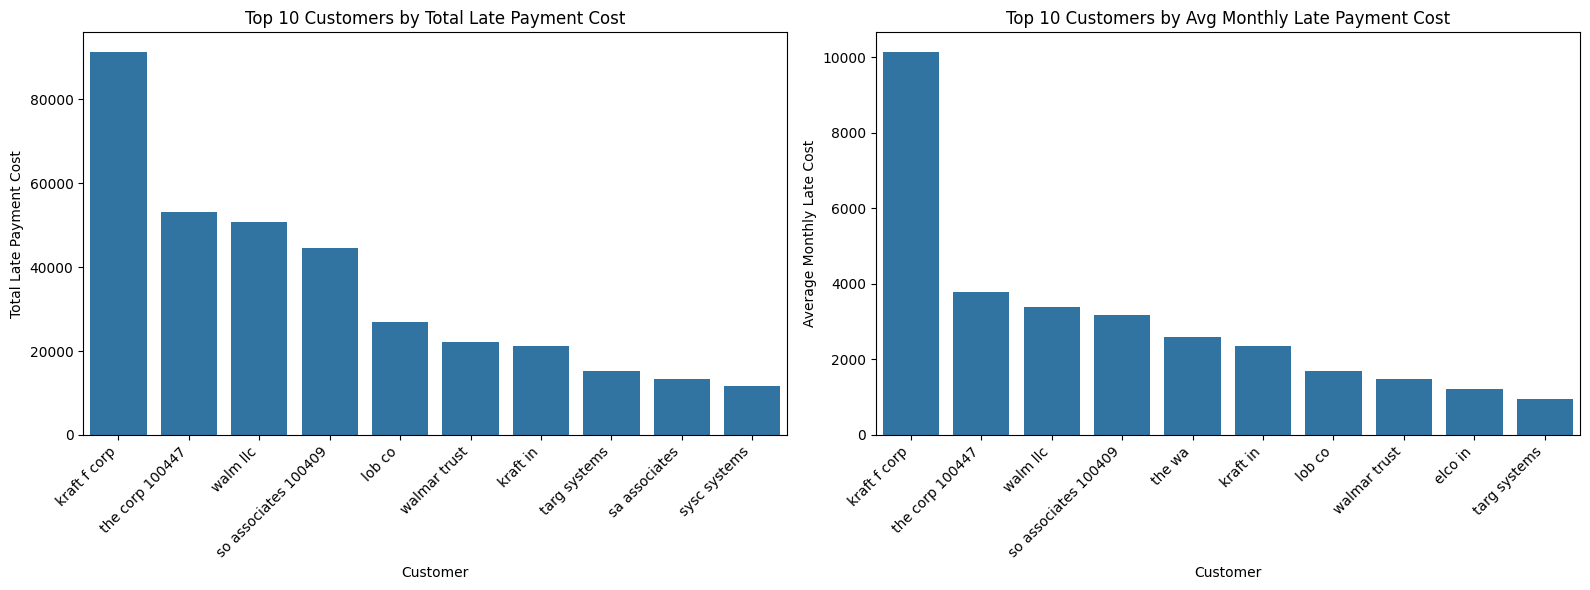

In [15]:
# Välj topp 10 för total och för snitt per månad
top10_total = (
    customer_cost_stats
    .sort_values("total_late_cost", ascending=False)
    .head(10)
)

top10_monthly = (
    customer_cost_stats
    .sort_values("avg_monthly_late_cost", ascending=False)
    .head(10)
)

plt.figure(figsize=(16,6))

# --- Vänster: total kostnad ---
plt.subplot(1, 2, 1)
sns.barplot(
    data=top10_total,
    x="customer_display_name",
    y="total_late_cost"
)
plt.title("Top 10 Customers by Total Late Payment Cost")
plt.ylabel("Total Late Payment Cost")
plt.xlabel("Customer")
plt.xticks(rotation=45, ha="right")

# --- Höger: snitt per månad ---
plt.subplot(1, 2, 2)
sns.barplot(
    data=top10_monthly,
    x="customer_display_name",
    y="avg_monthly_late_cost"
)
plt.title("Top 10 Customers by Avg Monthly Late Payment Cost")
plt.ylabel("Average Monthly Late Cost")
plt.xlabel("Customer")
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()

In [31]:
# Kostnad för försenat utskick (skapad faktura skickas senare)
creation_date = df[["document_create_date", "document_create_date.1"]].min(axis=1)

# Dagar från skapadatum till skickadatum
df["send_delay_days"] = (df["posting_date"] - creation_date).dt.days

# ---- NYTT: inför tolerans ----
# Räknas som fördröjt endast om > 1 dag
df["send_delay_days"] = df["send_delay_days"].apply(lambda x: x if x > 1 else 0)

send_delay_mask = df["send_delay_days"] > 0

# Kalkylränta
annual_rate = 0.10
daily_rate = annual_rate / 365

df["send_delay_cost"] = df["total_open_amount"] * daily_rate * df["send_delay_days"]

# Utskrifter
total_send_delay_cost = df.loc[send_delay_mask, "send_delay_cost"].sum()
median_send_delay_cost = df.loc[send_delay_mask, "send_delay_cost"].median()

percentiles = df.loc[send_delay_mask, "send_delay_cost"].quantile([0.50, 0.75, 0.90, 0.95])

print(f"Antal fakturor med fördröjt utskick (>1 dag): {send_delay_mask.sum()} av {len(df)}")
print(f"Total kostnad för förlängd betalningsfrist pga utskick: ${total_send_delay_cost:,.2f}")
print(f"Median kostnad per faktura: ${median_send_delay_cost:,.2f}")

print("Percentiler (kostnad per faktura):")
for pct, value in percentiles.items():
    print(f"P{int(pct*100):>2}: ${value:,.2f}")


Antal fakturor med fördröjt utskick (>1 dag): 10735 av 50000
Total kostnad för förlängd betalningsfrist pga utskick: $208,174.90
Median kostnad per faktura: $11.92
Percentiler (kostnad per faktura):
P50: $11.92
P75: $26.10
P90: $45.24
P95: $62.06


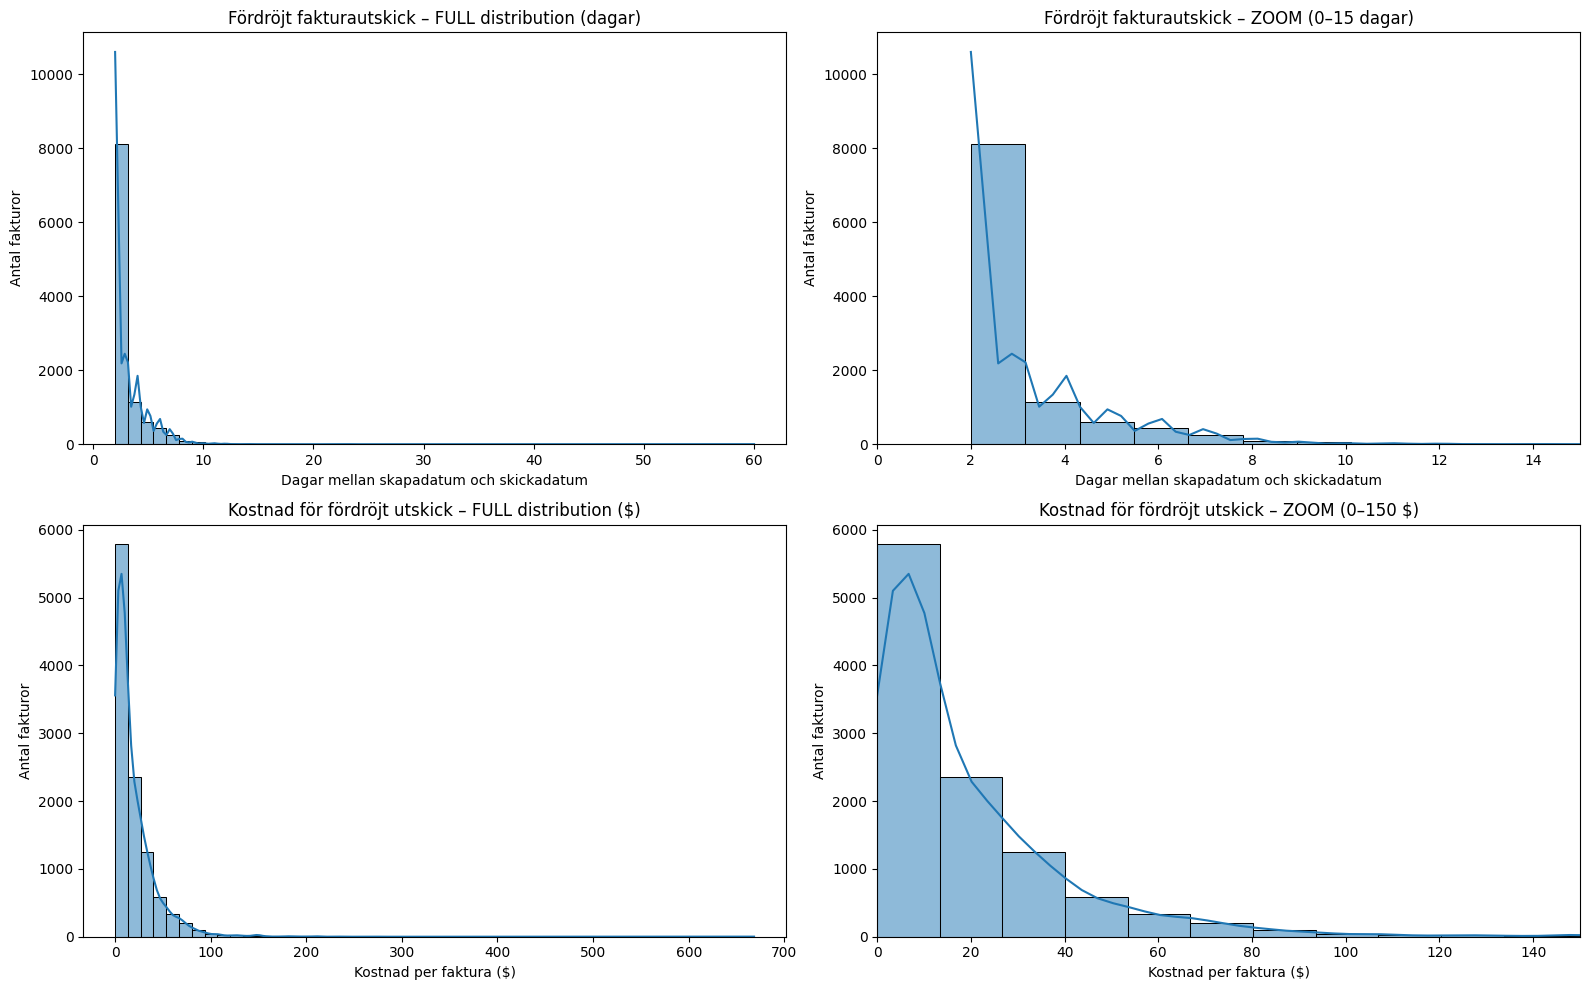

In [40]:
fig, axes = plt.subplots(2, 2, figsize=(16,10))

# --------------------------
# 1. FULL - send_delay_days
# --------------------------
sns.histplot(
    df.loc[send_delay_mask, "send_delay_days"],
    bins=50, kde=True,
    ax=axes[0, 0]
)
axes[0, 0].set_title("Fördröjt fakturautskick – FULL distribution (dagar)")
axes[0, 0].set_xlabel("Dagar mellan skapadatum och skickadatum")
axes[0, 0].set_ylabel("Antal fakturor")

# --------------------------
# 2. ZOOM - send_delay_days (limit = 15)
# --------------------------
sns.histplot(
    df.loc[send_delay_mask, "send_delay_days"],
    bins=50, kde=True,
    ax=axes[0, 1]
)
axes[0, 1].set_xlim(0, 15)
axes[0, 1].set_title("Fördröjt fakturautskick – ZOOM (0–15 dagar)")
axes[0, 1].set_xlabel("Dagar mellan skapadatum och skickadatum")
axes[0, 1].set_ylabel("Antal fakturor")

# --------------------------
# 3. FULL - send_delay_cost
# --------------------------
sns.histplot(
    df.loc[send_delay_mask, "send_delay_cost"],
    bins=50, kde=True,
    ax=axes[1, 0]
)
axes[1, 0].set_title("Kostnad för fördröjt utskick – FULL distribution ($)")
axes[1, 0].set_xlabel("Kostnad per faktura ($)")
axes[1, 0].set_ylabel("Antal fakturor")

# --------------------------
# 4. ZOOM - send_delay_cost (limit = 150)
# --------------------------
sns.histplot(
    df.loc[send_delay_mask, "send_delay_cost"],
    bins=50, kde=True,
    ax=axes[1, 1]
)
axes[1, 1].set_xlim(0, 150)
axes[1, 1].set_title("Kostnad för fördröjt utskick – ZOOM (0–150 $)")
axes[1, 1].set_xlabel("Kostnad per faktura ($)")
axes[1, 1].set_ylabel("Antal fakturor")

plt.tight_layout()
plt.show()

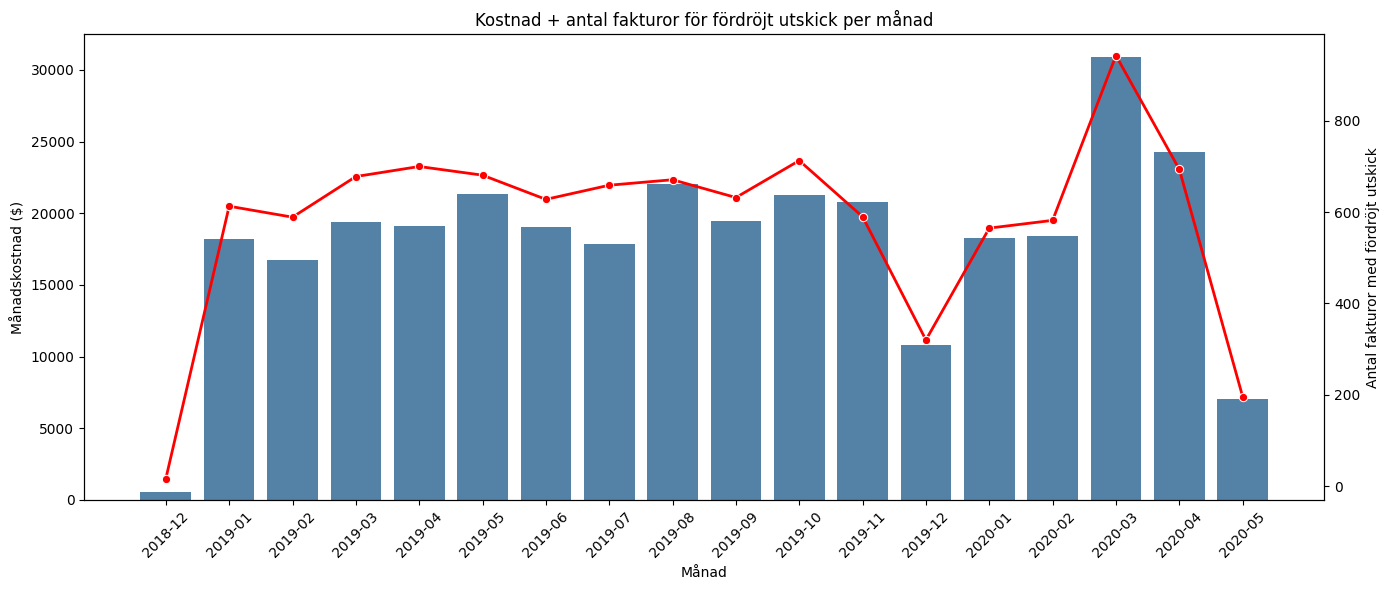

In [ ]:
# Antal fakturor per månad
monthly_send_delay_count = (
    df.loc[send_delay_mask]
    .assign(send_delay_month=lambda x: x["posting_date"].dt.to_period("M"))
    .groupby("send_delay_month")["invoice_id"]
    .nunique()
    .reset_index(name="n_late_sent")
)

# Kombinera
monthly_summary_send = monthly_send_delay.merge(
    monthly_send_delay_count,
    on="send_delay_month",
    how="left"
)

# Gör månad som sträng
monthly_summary_send["send_delay_month_str"] = monthly_summary_send["send_delay_month"].astype(str)

# Plot
fig, ax1 = plt.subplots(figsize=(14,6))

# Staplar = kostnad
sns.barplot(
    data=monthly_summary_send,
    x="send_delay_month_str",
    y="monthly_send_delay_cost",
    ax=ax1,
    color="steelblue"
)
ax1.set_ylabel("Månadskostnad ($)")
ax1.set_xlabel("Månad")
ax1.tick_params(axis='x', rotation=45)
ax1.ticklabel_format(style='plain', axis='y')

# Linje = antal fakturor
ax2 = ax1.twinx()
sns.lineplot(
    data=monthly_summary_send,
    x="send_delay_month_str",
    y="n_late_sent",
    ax=ax2,
    marker="o",
    color="red",
    linewidth=2
)
ax2.set_ylabel("Antal fakturor med fördröjt utskick")
ax2.ticklabel_format(style='plain', axis='y')

plt.title("Kostnad + antal fakturor för fördröjt utskick per månad")
plt.tight_layout()
plt.show()


In [35]:
customer_send_delay = (
    df.loc[send_delay_mask]
    .groupby(["customer_alt_id", "customer_display_name"])
    .agg(
        total_send_cost=("send_delay_cost", "sum"),
        avg_send_cost=("send_delay_cost", "mean"),
        n_sent=("invoice_id", "nunique"),
        total_days=("send_delay_days", "sum"),
    )
    .sort_values("total_send_cost", ascending=False)
    .reset_index()
)

customer_send_delay.head(10)


,customer_alt_id,customer_display_name,total_send_cost,avg_send_cost,n_sent,total_days
0,100908,walmar trust,37828.267633,14.372442,2571,5956
1,100885,sa associates,10357.285397,20.673224,487,1194
2,100986,cost corporation,7446.301751,15.944972,447,1170
3,100891,cs wh systems,5948.369570,21.320321,270,637
4,100764,publi llc,5789.102271,51.230994,109,290
5,101095,kraft in,5627.197885,24.360164,224,672
6,100994,mcl corporation,4376.047542,27.350297,154,682
7,101098,kraft f corp,4158.332118,10.885686,377,1213
8,100761,king s associates,3803.730836,32.510520,113,280
9,100913,safew co,3558.983718,31.776640,110,247
